In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/GB1/gb1.tsv', sep='\t')

In [4]:
df.nunique()
df.columns
# Index(['variant', 'num_mutations', 'inp', 'sel', 'score'], dtype='object')

Index(['variant', 'num_mutations', 'inp', 'sel', 'score'], dtype='object')

In [5]:
from Bio.PDB import *

# data_exploration\data\GB1\2qmt.pdb

# read seqence from pdb file

parser = PDBParser()
structure = parser.get_structure('2qmt', './data/GB1/2qmt.pdb')
# Initialize the polypeptide builder
ppb = PPBuilder()

# Extract and print amino acid sequences
for i, polypeptide in enumerate(ppb.build_peptides(structure), start=1):
    sequence = polypeptide.get_sequence()  # Get the sequence as a Seq object
    print(f"Polypeptide {i}: {sequence}")
sequence

# df
# variant	num_mutations	inp	sel	score
# 0	Q1A	1	14663.0	38476.0	0.417326
# 1	Q1C	1	13001.0	23023.0	0.024091
# 2	Q1D	1	11488.0	18085.0	-0.093596
# 3	Q1E	1	9501.0	15629.0	-0.049649
# 4	Q1F	1	4770.0	13332.0	0.480394
# ...	...	...	...	...	...
# 536079	E55Y,T54R	2	462.0	139.0	-1.745942
# 536080	E55Y,T54S	2	317.0	84.0	-1.871086
# 536081	E55Y,T54V	2	335.0	77.0	-2.012704
# 536082	E55Y,T54W	2	148.0	28.0	-2.198041
# 536083	E55Y,T54Y	2	95.0	16.0	-2.303126

# build all the possible mutations

# get the sequence
sequence = str(sequence)

def build_mutations(variant, sequence):
    wildtype = sequence
    mutations = variant.split(',')
    for mutation in mutations:
        pos = int(mutation[1:-1])
        aa = mutation[-1]
        wildtype = wildtype[:pos] + aa + wildtype[pos+1:]
    return wildtype

df['sequence'] = df['variant'].apply(lambda x: build_mutations(x, sequence))

df.nunique()

Polypeptide 1: MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE


variant          536084
num_mutations         2
inp                8873
sel               10149
score            235500
sequence         536084
dtype: int64

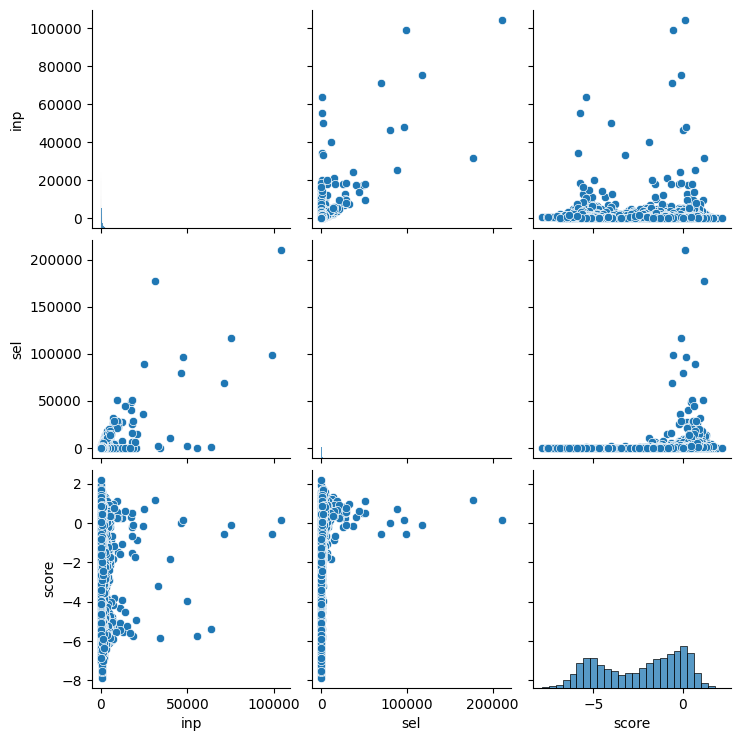

In [ ]:
#randomly select 10000 samples

df_s = df.sample(10000)

sns.pairplot(df_s[['inp', 'sel', 'score']])



In [11]:
# Import necessary libraries
from transformers import AutoTokenizer, EsmModel
import torch
import csv
import os
import pandas as pd  # Assuming df is a DataFrame
from tqdm import tqdm  # For progress tracking

# Configure device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

# 1. Load the model and tokenizer
model_name = "esm2_t6_8M_UR50D"
model_path = f"facebook/{model_name}"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = EsmModel.from_pretrained(model_path).to(device)

# Path to the CSV file
csv_path = f"./data/GB1/{model_name}_emb.csv"

# Check if the file already exists and read processed variants
processed_variants = set()
if os.path.exists(csv_path):
    with open(csv_path, "r", newline="") as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        processed_variants = {row[0] for row in reader}  # Collect processed variants

# Open the file in append mode if it exists, otherwise write mode
mode = "a" if os.path.exists(csv_path) else "w"

# Batch size configuration
BATCH_SIZE = 32  # Adjust based on GPU memory

# Prepare sequences to process
sequences_to_process = [seq for seq in df["sequence"].unique() if seq not in processed_variants]
print(f"Total sequences to process: {len(sequences_to_process)}")

# Write embeddings in batches
with open(csv_path, mode, newline="") as file:
    writer = csv.writer(file)
    if mode == "w":
        writer.writerow(["sequence", "embedding"])  # Write header if creating a new file

    # Process sequences in batches
    for i in tqdm(range(0, len(sequences_to_process), BATCH_SIZE), desc="Processing Batches"):
        batch_sequences = sequences_to_process[i:i + BATCH_SIZE]
        
        # Tokenize the batch
        batch = tokenizer(batch_sequences, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Perform inference
        with torch.no_grad():
            hs = model(**batch, output_hidden_states=True).last_hidden_state
            embeddings = torch.mean(hs, dim=1).cpu().numpy()  # Compute mean along sequence dimension

        # Write the results to the CSV
        for seq, emb in zip(batch_sequences, embeddings):
            writer.writerow([seq, emb.tolist()])


cpu


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total sequences to process: 535220


Processing Batches:   0%|          | 4/16726 [03:54<272:05:37, 58.58s/it] 


KeyboardInterrupt: 